---
title: T2M Nonstationary - EDA
subject: AEMET T2M
short_title: 2 - Model
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CSIC
      - UCM
      - IGEO
    orcid: 0000-0002-6739-0053
    email: juanjohn@ucm.es
license: CC-BY-4.0
keywords: notation
---

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
import multiprocessing

num_devices = multiprocessing.cpu_count()
numpyro.set_platform("cpu")
# numpyro.set_host_device_count(4)
# num_chains = 5
numpyro.set_host_device_count(num_devices)

In [2]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray
from omegaconf import OmegaConf

from st_evt.utils import ExperimentPath

import jax
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd

rng_key = jrandom.PRNGKey(123)

from numpyro.infer import Predictive
import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Data

In [3]:
config_file_name = "/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/config/config.json"
config = OmegaConf.load(config_file_name)

config

{'experiment_name': 'walkthrough/ts_station_stationary', 'dataset': 'aemet', 'station_id': '8414A', 'variable': 't2m', 'likelihood': 'gevd', 'freq': 'summer', 'dependence': 'temporal', 'parameterization': 'linear', 'config_file_name': 'aemet_station_nonstationary.yaml', 'covariate_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/gmst.zarr', 'dataset_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/t2m_stations_spain.zarr', 'exp_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary', 'figures_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/figures/eda', 'data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data', 'clean_data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data/clean_data.nc', 'mcmc_results_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data/mcmc_results.nc'}

### Data

In [4]:
root_path = Path(config["exp_path"])
clean_data_path = Path(config["clean_data_path"])
covariate_data_path = Path(config["covariate_path"])


exp_file_config = ExperimentPath(root_dir=root_path)
figures_path = exp_file_config.figures_model_dir
data_path = exp_file_config.data_dir

### Statistics summary

In [5]:
# LOAD DATA
with xr.open_dataset(clean_data_path, engine="netcdf4") as f:
    ds_bm = f.load()
ds_bm

<xarray.Dataset> Size: 1kB
Dimensions:          (gmst: 60, station_id: 1, quantile: 5)
Coordinates:
    alt              (station_id) float32 4B 56.0
    lat              (station_id) float32 4B 39.48
    lon              (station_id) float32 4B -0.476
    red_feten_mask   (station_id) uint8 1B 1
  * station_id       (station_id) <U5 20B '8414A'
    station_name     (station_id) <U20 80B 'valencia, aeropuerto'
    time             (gmst) datetime64[ns] 480B 1961-12-31 ... 2020-12-31
  * gmst             (gmst) float64 480B 0.1988 0.1827 0.1587 ... 1.133 1.196
  * quantile         (quantile) float64 40B 0.9 0.95 0.98 0.99 0.995
Data variables:
    t2m_max_bm_year  (gmst, station_id) float32 240B 35.8 43.4 ... 42.4 36.5
    threshold        (quantile) float64 40B 33.0 34.5 36.4 37.6 38.65

In [9]:
variable_bm = "t2m_max_bm_year"

y = ds_bm[variable_bm].values.squeeze()
t = ds_bm.gmst.values.squeeze()
t_pred = np.linspace(0.0, 2.5, 100)
t.shape, t_pred.shape, y.shape

((60,), (100,), (60,))

### Hierarchical Parameterization

In [10]:
# initialize empirical values
empirical_loc = ds_bm[variable_bm].mean().values.squeeze()
empirical_std = ds_bm[variable_bm].std().values.squeeze()

print(f"Loc: {empirical_loc.squeeze():.2f}")
print(f"Scale: {empirical_std.squeeze():.2f}")

empirical_loc_log = np.log(empirical_loc)
empirical_std_log = np.log(empirical_std)

print(f"Loc (log): {empirical_loc_log:.2f}")
print(f"Scale (log): {empirical_std_log:.2f}")

Loc: 37.87
Scale: 2.42
Loc (log): 3.63
Scale (log): 0.88


## Model

In [11]:
import numpyro
from jaxtyping import Array
import numpyro.distributions as dist
from tensorflow_probability.substrates.jax import distributions as tfd


def model(t: Array, y=None, *args, **kwargs):

    num_timesteps = t.shape[0]

    plate_time = numpyro.plate("time", num_timesteps, dim=-1)


    # LOCATION PARAMETERS
    weight_prior = dist.Normal(0.0, 1.0)
    location_weight = numpyro.sample("location_weight", fn=weight_prior)

    bias_prior = dist.Normal(empirical_loc, empirical_std)
    location_bias = numpyro.sample("location_bias", fn=bias_prior)
    location = numpyro.deterministic("location", location_weight * t + location_bias)

    # SCALE PARAMETER
    scale_prior = dist.LogNormal(1.0, 0.5)
    scale = numpyro.sample("scale", fn=scale_prior)

    # SHAPE Parameter
    concentration_prior = dist.TruncatedNormal(-0.3, 0.1, low=-1.0, high=-1e-5)
    concentration = numpyro.sample("concentration", fn=concentration_prior)

    # create likelihood distribution
    with plate_time:
        y_dist = tfd.GeneralizedExtremeValue(loc=location, scale=scale, concentration=concentration)
        y = numpyro.sample("obs", y_dist, obs=y)

    return y

In [12]:
with numpyro.handlers.seed(rng_seed=123):
    y_sample = model(t=t)



### Prior Predictions

In [13]:
import arviz as az

In [14]:
from numpyro.infer import Predictive

rng_key, rng_key_ = jrandom.split(rng_key)
prior_predictive = Predictive(model, num_samples=1_000)
prior_samples = prior_predictive(rng_key_, t=t)

In [15]:
az_ds_prior = az.from_numpyro(
    prior=prior_samples,
    dims={
        "obs": ["time"],
        "location": ["time"]
    }
    # pred_dims={"obs": ["time"]}
)

In [16]:
az_ds_prior

Inference data with groups:
	> prior

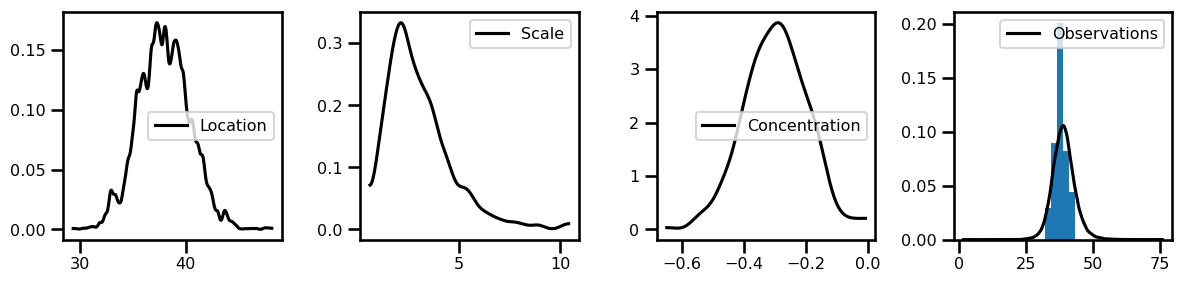

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(12,3))

az.plot_dist(prior_samples["location"], kind="kde", color="black", label="Location", ax=ax[0])
az.plot_dist(prior_samples["scale"], kind="kde", color="black", label="Scale", ax=ax[1])
az.plot_dist(prior_samples["concentration"], kind="kde", color="black", label="Concentration", ax=ax[2])
az.plot_dist(prior_samples["obs"], kind="kde", color="black", label="Observations", ax=ax[3], plot_kwargs=dict(zorder=3))
ax[3].hist(y.ravel(), density=True, bins=5)

fig.savefig(figures_path.joinpath("density_prior.png"))

fig.set(
    dpi=100,
    size_inches=(12,3)
)

plt.tight_layout()
plt.show()

## Inference

In this example, we will use MCMC. We only have 3 parameters so this will be relatively quick.

In [18]:
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, init_to_value, init_to_median

num_samples = 1_000
num_warmup = 10_000

num_chains = 4

sampler = NUTS(
    model,
    init_strategy=init_to_median(num_samples=10)
)

mcmc = MCMC(
    sampler=sampler,
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    
)

# create key
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

# RUN MCMC SAMPLER
mcmc.run(rng_key_train, t=t, y=y)

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

In [19]:
mcmc.print_summary(exclude_deterministic=True)


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
    concentration     -0.25      0.06     -0.25     -0.36     -0.15   1392.16      1.00
    location_bias     36.76      0.52     36.77     35.95     37.64   1519.76      1.00
  location_weight      0.42      0.70      0.42     -0.79      1.52   1668.99      1.00
            scale      2.47      0.25      2.45      2.08      2.89   1797.55      1.00

Number of divergences: 109


## Posterior

In [20]:
posterior_samples = mcmc.get_samples()

In [21]:
az_ds = az.from_numpyro(
    posterior=mcmc,
    dims={
        "location": ["gmst"],
        "scale": [],
        "concentration": [],
        "obs": ["gmst"]
    },
    pred_dims={
        "obs": ["gmst"],
        "location": ["gmst"],
    },
    # coords={"time": t_pred}
)
# correct coordinates
az_ds = az_ds.assign_coords({"gmst": ds_bm.gmst})



az_ds

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Posterior Predictive

In [22]:
# Get Posterior Samples
predictive = Predictive(
    model=model, posterior_samples=posterior_samples, parallel=True, 
    return_sites=[
        "location", "scale", "concentration", "obs"
    ]
)
# Posterior predictive samples
rng_key, rng_subkey = jrandom.split(rng_key)

posterior_predictive_samples = predictive(rng_subkey, t=t)

list(posterior_predictive_samples.keys())

['concentration', 'location', 'obs', 'scale']

In [23]:
az_ds_postpred = az.from_numpyro(
    # posterior=mcmc,
    posterior_predictive=posterior_predictive_samples,
    dims={
        "location": ["gmst"],
        "scale": [],
        "concentration": [],
        "obs": ["gmst"]
    },
    pred_dims={
        "obs": ["gmst"],
        "location": ["gmst"],
    },
    # coords={"time": t_pred}
)
# correct coordinates
az_ds_postpred = az_ds_postpred.assign_coords({"gmst": t})



az_ds_postpred

Inference data with groups:
	> posterior_predictive

### Predictions

In [24]:
# Get Posterior Samples
predictive = Predictive(
    model=model, posterior_samples=posterior_samples, parallel=True, 
    return_sites=[
        "location", "scale", "concentration", "obs"
    ]
)
# Posterior predictive samples
rng_key, rng_subkey = jrandom.split(rng_key)

prediction_samples = predictive(rng_subkey, t=t_pred)

list(prediction_samples.keys())

['concentration', 'location', 'obs', 'scale']

In [25]:
az_ds_preds = az.from_numpyro(
    # posterior=mcmc,
    predictions=prediction_samples,
    pred_dims={
        "obs": ["gmst"],
        "location": ["gmst"],
    },
    # coords={"time": t_pred}
)
# correct coordinates
az_ds_preds = az_ds_preds.assign_coords({"gmst": t_pred})



az_ds_preds

Inference data with groups:
	> predictions

### Combined Results

In [26]:
az_ds.add_groups(az_ds_postpred)
az_ds.add_groups(az_ds_preds)
az_ds.add_groups(az_ds_prior)
az_ds

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

#### MCMC Statistics

In [27]:
stats = az.waic(az_ds)
stats

/home/juanjohn/miniconda/envs/stevt/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 60 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -140.61     5.43
p_waic        2.67        -

There has been a warning during the calculation. Please check the results.

In [28]:

az_ds.log_likelihood.attrs["elpd_waic"] = stats.elpd_waic
az_ds.log_likelihood.attrs["se"] = stats.se
az_ds.log_likelihood.attrs["p_waic"] = stats.p_waic

#### Threshold

In [29]:
# calculate threshold, per station
az_ds.posterior["threshold"] = ds_bm.threshold
az_ds.posterior

<xarray.Dataset> Size: 1MB
Dimensions:          (chain: 4, draw: 1000, gmst: 60, quantile: 5)
Coordinates:
  * chain            (chain) int64 32B 0 1 2 3
  * draw             (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
    time             (gmst) datetime64[ns] 480B 1961-12-31 ... 2020-12-31
  * gmst             (gmst) float64 480B 0.1988 0.1827 0.1587 ... 1.133 1.196
  * quantile         (quantile) float64 40B 0.9 0.95 0.98 0.99 0.995
Data variables:
    concentration    (chain, draw) float32 16kB -0.2638 -0.2676 ... -0.2222
    location         (chain, draw, gmst) float32 960kB 36.76 36.75 ... 37.27
    location_bias    (chain, draw) float32 16kB 36.65 36.69 37.1 ... 37.3 36.56
    location_weight  (chain, draw) float32 16kB 0.5572 0.5058 ... 0.5864
    scale            (chain, draw) float32 16kB 2.29 2.418 2.683 ... 2.424 2.299
    threshold        (quantile) float64 40B 33.0 34.5 36.4 37.6 38.65
Attributes:
    created_at:                 2024-12-04T15:34:34.953166+00:00
    arviz_version:              0.20.0
    inference_library:          numpyro
    inference_library_version:  0.16.0

### Save Data

In [30]:
mcmc_results_path = data_path.joinpath("mcmc_results.nc")
az_ds.to_netcdf(filename=mcmc_results_path)

PosixPath('/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data/mcmc_results.nc')

In [31]:
config["mcmc_results_path"] = str(mcmc_results_path)

In [32]:
OmegaConf.save(config, config_file_name)

In [33]:
!cat $config_file_name

experiment_name: walkthrough/ts_station_stationary
dataset: aemet
station_id: 8414A
variable: t2m
likelihood: gevd
freq: summer
dependence: temporal
parameterization: linear
config_file_name: aemet_station_nonstationary.yaml
covariate_path: /home/juanjohn/pool_data/dynev4eo/data/clean/gmst.zarr
dataset_path: /home/juanjohn/pool_data/dynev4eo/data/clean/t2m_stations_spain.zarr
exp_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary
figures_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/figures/eda
data_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data
clean_data_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data/clean_data.nc
mcmc_results_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data/mcmc_results.nc


/home/juanjohn/miniconda/envs/stevt/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
